# 2.4 Machine learning: Classifying miRNA precursors across species

In [27]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import itertools

# ---------------------------------------------------------
# CONFIGURATION
# ---------------------------------------------------------
INPUT_FILE = "merged_data_final.xlsx"
SEED = 42
ORGANISMS = ["Human", "House mouse", "Fruit fly", "Roundworm"]
FEATURES = [
    'MFE', 'Mature_BP_Count', 'Star_BP_Count', 'Terminal_Loop_Size', 
    'GC_Pairs_Precursor', 'AU_Pairs_Precursor', 'GU_Pairs_Precursor', 
    'Mature_Unmatched_Count', 'Star_Unmatched_Count', 'Precursor_Unmatched_Count', 
    'Mature_Max_Consecutive_Unmatched', 'Star_Max_Consecutive_Unmatched'
]

# ---------------------------------------------------------
# 1. LOAD DATA
# ---------------------------------------------------------
print("🔄 Loading data...")
try:
    xls = pd.ExcelFile(INPUT_FILE)
    
    # Global Dictionary to store raw data for plotting later
    data_dict = {}
    
    for org in ORGANISMS:
        if org in xls.sheet_names:
            df = pd.read_excel(xls, sheet_name=org)
            # Select features and drop missing values
            data_dict[org] = df[FEATURES].dropna().copy()
            print(f"   Loaded {org}: {len(data_dict[org])} rows")
        else:
            print(f"   ⚠️ Warning: Sheet '{org}' not found.")

except FileNotFoundError:
    print(f"❌ Error: {INPUT_FILE} not found.")
    data_dict = {}

# ---------------------------------------------------------
# 2. RUN ML MODELS
# ---------------------------------------------------------
if data_dict:
    print("\n🚀 Starting Pairwise Classification (Random Forest)...")
    results = []
    pairs = list(itertools.combinations(data_dict.keys(), 2))

    for org1, org2 in pairs:
        # Prepare Data
        df1 = data_dict[org1].copy()
        df2 = data_dict[org2].copy()
        df1['target'] = 0
        df2['target'] = 1
        
        combined = pd.concat([df1, df2], axis=0).reset_index(drop=True)
        
        # Split
        X = combined[FEATURES]
        y = combined['target']
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=SEED, stratify=y
        )
        
        # Train
        clf = RandomForestClassifier(n_estimators=100, random_state=SEED)
        clf.fit(X_train, y_train)
        
        # Evaluate
        y_proba = clf.predict_proba(X_test)[:, 1]
        y_pred = clf.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)
        
        # Feature Importance
        imp_dict = dict(zip(FEATURES, clf.feature_importances_))
        sorted_imp = sorted(imp_dict.items(), key=lambda x: x[1], reverse=True)
        
        print(f"   {org1} vs {org2}: Accuracy={acc:.4f} | ROC-AUC={auc:.4f}")
        
        results.append({
            'Comparison': f"{org1} vs {org2}",
            'Accuracy': acc,
            'ROC_AUC': auc,
            'Importances': imp_dict,
            'Top_Feature': sorted_imp[0][0]
        })

    # Save results to Global DataFrame
    summary_df = pd.DataFrame(results)
    print("\n✅ Analysis Complete. 'summary_df' and 'data_dict' are ready.")

🔄 Loading data...
   Loaded Human: 514 rows
   Loaded House mouse: 404 rows
   Loaded Fruit fly: 140 rows
   Loaded Roundworm: 138 rows

🚀 Starting Pairwise Classification (Random Forest)...
   Human vs House mouse: Accuracy=0.4348 | ROC-AUC=0.3031
   Human vs Fruit fly: Accuracy=0.8244 | ROC-AUC=0.7731
   Human vs Roundworm: Accuracy=0.7710 | ROC-AUC=0.8121
   House mouse vs Fruit fly: Accuracy=0.7523 | ROC-AUC=0.6903
   House mouse vs Roundworm: Accuracy=0.8073 | ROC-AUC=0.7720
   Fruit fly vs Roundworm: Accuracy=0.6964 | ROC-AUC=0.7455

✅ Analysis Complete. 'summary_df' and 'data_dict' are ready.


# 2.5 Summary and Interpretation

📊 Generating Visualizations...


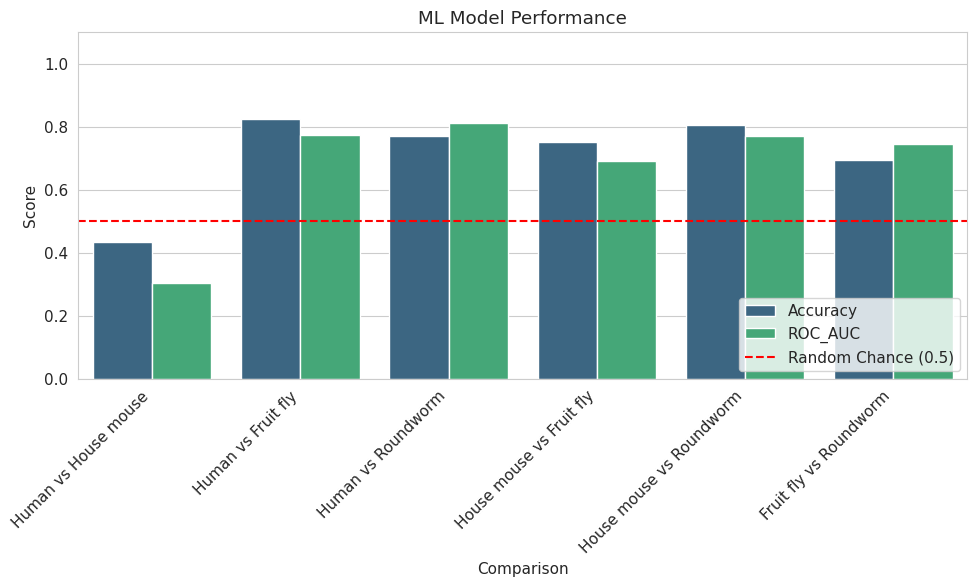

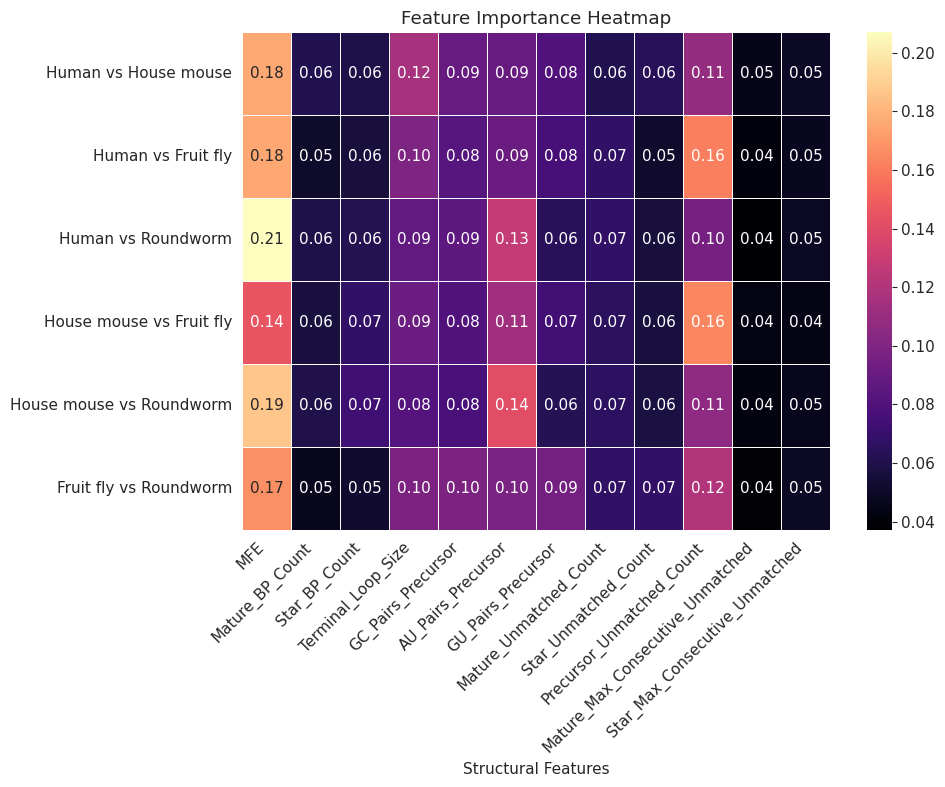

Top 3 Discriminative Features: ['MFE', 'Precursor_Unmatched_Count', 'AU_Pairs_Precursor']


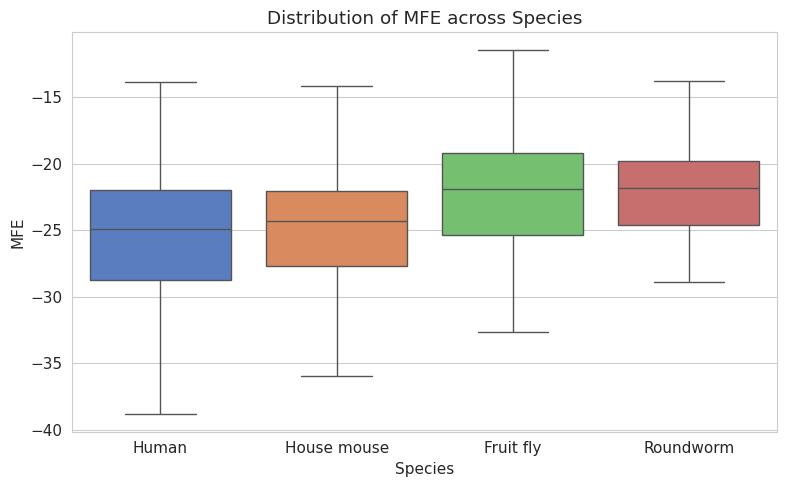

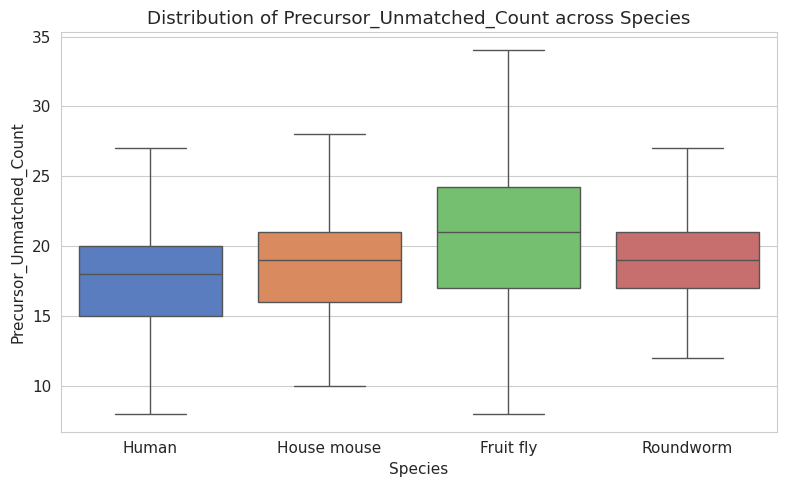

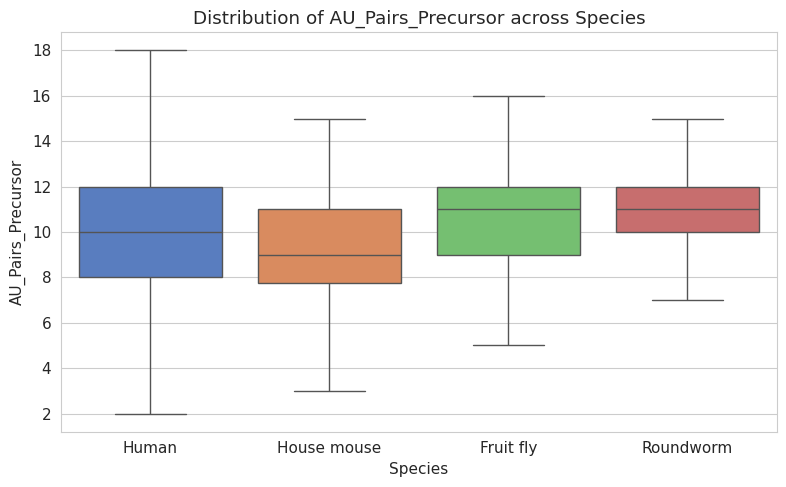

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure plots appear in the notebook
%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 11})

# Check if data exists
if 'summary_df' not in locals() or 'data_dict' not in locals():
    print("❌ Error: Run Block 1 first to generate results.")
else:
    print("📊 Generating Visualizations...")

    # -------------------------------------------------------
    # PLOT 1: ML PERFORMANCE BAR CHART
    # -------------------------------------------------------
    plt.figure(figsize=(10, 6))
    perf_melt = summary_df.melt(
        id_vars=['Comparison'], 
        value_vars=['Accuracy', 'ROC_AUC'], 
        var_name='Metric', 
        value_name='Score'
    )
    
    sns.barplot(data=perf_melt, x='Comparison', y='Score', hue='Metric', palette="viridis")
    plt.axhline(0.5, color='red', linestyle='--', label='Random Chance (0.5)')
    plt.xticks(rotation=45, ha='right')
    plt.title('ML Model Performance')
    plt.ylim(0, 1.1)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

    # -------------------------------------------------------
    # PLOT 2: FEATURE IMPORTANCE HEATMAP
    # -------------------------------------------------------
    # Reconstruct DataFrame from dicts inside summary_df
    imp_data = {row['Comparison']: row['Importances'] for i, row in summary_df.iterrows()}
    imp_df = pd.DataFrame(imp_data).T
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(imp_df, annot=True, fmt=".2f", cmap="magma", linewidths=.5)
    plt.title('Feature Importance Heatmap')
    plt.xlabel('Structural Features')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # -------------------------------------------------------
    # PLOT 3: EVOLUTIONARY DISTRIBUTIONS (BOXPLOTS)
    # -------------------------------------------------------
    # Combine raw data for plotting
    all_data = []
    for species, df in data_dict.items():
        temp = df.copy()
        temp['Species'] = species
        all_data.append(temp)
    full_df = pd.concat(all_data)

    # Find Top 3 Global Features
    top_features = imp_df.sum().sort_values(ascending=False).head(3).index.tolist()
    print(f"Top 3 Discriminative Features: {top_features}")

    for feature in top_features:
        plt.figure(figsize=(8, 5))
        # FIXED LINE BELOW: Added hue='Species' and legend=False
        sns.boxplot(
            x='Species', 
            y=feature, 
            hue='Species', 
            legend=False, 
            data=full_df, 
            palette="muted", 
            showfliers=False
        )
        plt.title(f'Distribution of {feature} across Species')
        plt.tight_layout()
        plt.show()

📝 Generating Report Data...

------- TABLE FOR REPORT: MEAN VALUES (+/- STD) -------
Species                  Fruit fly  House mouse  Human  Roundworm
MFE                mean     -22.80       -24.92 -25.68     -22.60
                   std        6.28         4.73   5.27       5.06
GC_Pairs_Precursor mean       8.64         9.40   9.24       8.97
                   std        2.96         2.27   2.39       2.11
Terminal_Loop_Size mean       8.78         7.87   7.54       8.25
                   std        4.53         3.81   3.40       3.56
-------------------------------------------------------


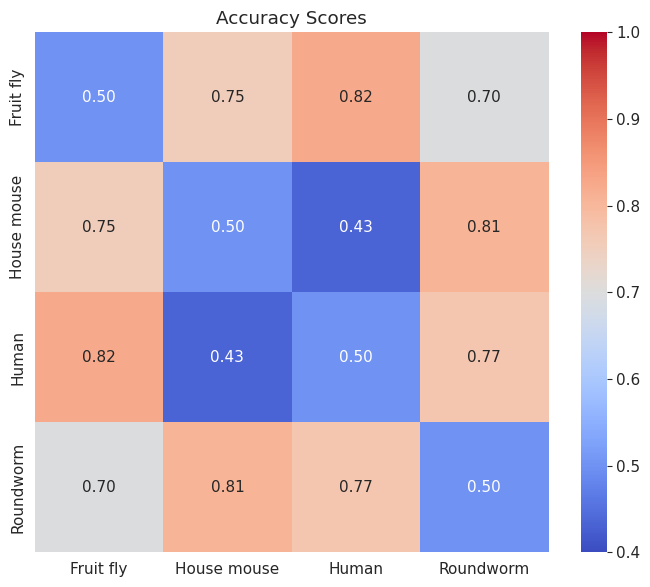

✅ Evolutionary Matrix Generated.


In [26]:
# ---------------------------------------------------------
# BLOCK 3: REPORT DATA
# ---------------------------------------------------------
if 'summary_df' in locals() and 'data_dict' in locals():
    print("📝 Generating Report Data...")

    # 1. GENERATE STATS TABLE (For your text descriptions)
    # Combine all data
    all_data = []
    for species, df in data_dict.items():
        temp = df.copy()
        temp['Species'] = species
        all_data.append(temp)
    full_df = pd.concat(all_data)

    # Calculate Mean +/- Std for the top features
    # This gives you the exact numbers to write in your report
    stats_table = full_df.groupby('Species')[FEATURES].agg(['mean', 'std']).round(2)
    
    # We focus on the features the model found most important (e.g., MFE, GC)
    print("\n------- TABLE FOR REPORT: MEAN VALUES (+/- STD) -------")
    # Transposing makes it easier to read: Rows = Features, Cols = Species
    print(stats_table[['MFE', 'GC_Pairs_Precursor', 'Terminal_Loop_Size']].T)
    print("-------------------------------------------------------")


    # 2. GENERATE EVOLUTIONARY DISTANCE MATRIX (The "phylogeny" proof)
    # We want a square matrix where cell (i, j) is the Accuracy of distinguishing i from j.
    # High Accuracy = High Evolutionary Distance.
    
    # Create empty matrix
    species_list = sorted(list(data_dict.keys()))
    dist_matrix = pd.DataFrame(index=species_list, columns=species_list, dtype=float)

    # Fill diagonal with 0.5 (Random chance / Indistinguishable)
    for s in species_list:
        dist_matrix.loc[s, s] = 0.5

    # Fill with ML Accuracy results
    for idx, row in summary_df.iterrows():
        # Parsing "Species A vs Species B"
        s1, s2 = row['Comparison'].split(' vs ')
        acc = row['Accuracy']
        dist_matrix.loc[s1, s2] = acc
        dist_matrix.loc[s2, s1] = acc

    plt.figure(figsize=(7, 6))
    sns.heatmap(dist_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=0.4, vmax=1.0)
    plt.title('Accuracy Scores')
    plt.tight_layout()
    plt.show()
    print("✅ Evolutionary Matrix Generated.")
    
else:
    print("❌ Error: Run Block 1 first.")